# QR Code Reader


In [1]:
import maxflow as mx
from PIL import Image
from cv2 import imshow
from numpy import asarray, mgrid, uint8
from skimage.filters import sobel_h, sobel_v, gaussian
from skimage.color import hsv2rgb
from scipy.ndimage import median_filter
from scipy.ndimage import gaussian_filter
import scipy as sc
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.neighbors import KernelDensity
import numpy as np
import random
import math
import copy
from PIL import Image
from scipy import ndimage
from decoder import decode

In [2]:
# Your Code Here
class Point_Finder():
    def __init__(self,img_str):
        # Make Counters

        self.img_str = img_str
        self.tolerance = 1
        self.fil_tol = .45
        self.process_image()

    def process_image(self):
        image_unproc = cv.imread(self.img_str,cv.IMREAD_GRAYSCALE)
        # image_filtered = gaussian_filter(image_unproc, sigma=1)
        # image_filtered = median_filter(image_filtered,size=3)
        
        plt.imshow(image_unproc,cmap='gray');plt.show()
        image = image_unproc/255
        
        image = 1-image
        image[image>=self.fil_tol] = 1
        image[image<self.fil_tol] = 0
        

        self.image = image

        self.votes_img = np.zeros((image.shape))
    

    def vote(self):
        
        for i in (range(len(self.bw_data)-4)):
            
            curr_array = self.bw_data[i:i+5]
            curr_points = self.points_data[i:i+5]
        
            min_val = min(curr_array)

            if min_val != 0:
                norm_array = [x / min_val for x in curr_array]
                zero_list = []
                pattern = [1,1,3,1,1]
                for i in range(len(pattern)):
                    zero_list.append(norm_array[i] - pattern[i])
                abs_zeros = [abs(x) for x in zero_list]
                if all(i < self.tolerance for i in abs_zeros):
                    point1 = curr_points[2]
                    point2 = curr_points[3]

                    
                    vote_point_i = point1[0] + int((point2[0] - point1[0])/2)
                    vote_point_j = point1[1] + int((point2[1] - point1[1])/2)

                    self.votes_img[vote_point_i,vote_point_j] += 1
                

    def run(self):
        
    
        #horizontal
        for i in (range(len(self.image[0]))):
            counter = 0
            val = self.image[i][0]
            self.bw_data = []
            self.points_data = [[i,0]]
            for j in range(len(self.image)):
                curr_val = self.image[i][j]
                if val != curr_val:
                    self.points_data.append([i,j])
                    self.bw_data.append(counter)
                    counter = 0
                    val = curr_val
                counter += 1
            
            self.bw_data.append(counter)
            if i == 27:
                print(self.bw_data)
                print(self.points_data)
            self.vote()
        
        
        #vertical
        
        for j in (range(len(self.image[0]))):
            counter = 0
            val = self.image[0][j]
            self.bw_data = []
            self.points_data = [[0,j]]
            for i in range(len(self.image)):
                curr_val = self.image[i][j]
                if val != curr_val:
                    self.points_data.append([i,j])
                    self.bw_data.append(counter)
                    counter = 0
                    val = curr_val
                counter += 1
            
            self.bw_data.append(counter)
            self.vote()

        self.corner_points = []
        for i in range(3):
            x, y = np.unravel_index(self.votes_img.argmax(), self.votes_img.shape)
            self.corner_points.append([x,y])
            self.votes_img[x,y] = 0
        plt.imshow(self.votes_img);plt.show()
        return self.corner_points
    

In [3]:
def four_point(corners):
  def rotate_image(image, angle):
    rotated = ndimage.rotate(image, angle)
    rotated[rotated>=.6] = 1
    rotated[rotated<.6] = 0
    
    return rotated
  
  def check_quadrants(corners):
    x,y = pf.image.shape
    x_mid = x/2
    y_mid = y/2

    quad_1 = False
    quad_2 = False
    quad_3 = False
    quad_4 = False

    if corners[0][0] < x_mid:
      if corners[0][1] < y_mid:
        quad_2 = True
      else:
        quad_1 = True
    else:
      if corners[0][1] < y_mid:
        quad_3 = True
      else:
        quad_4 = True

    if corners[1][0] < x_mid:
      if corners[1][1] < y_mid:
        quad_2 = True
      else:
        quad_1 = True
    else:
      if corners[1][1] < y_mid:
        quad_3 = True
      else:
        quad_4 = True

    if corners[2][0] < x_mid:
      if corners[2][1] < y_mid:
        quad_2 = True
      else:
        quad_1 = True
    else:
      if corners[2][1] < y_mid:
        quad_3 = True
      else:
        quad_4 = True

    quadrants = [quad_1,quad_2,quad_3,quad_4]
    return quadrants
  
  
  
  def rotate_to_quadrant(q):
    if q == [True,True,True,False]:
      pass
    elif q == [False,True,True,True]:
      pf.image = rotate_image(pf.image,90*3)
      pf.votes_img = np.zeros((pf.image.shape))
    elif q == [True,False,True,True]:
      pf.image = rotate_image(pf.image,90*2)
      pf.votes_img = np.zeros((pf.image.shape))
    elif q == [True,True,False,True]:
      pf.image = rotate_image(pf.image,90)
      pf.votes_img = np.zeros((pf.image.shape))

  if(corners[0][0] != corners[1][0]):
    quadrants = check_quadrants(corners)
    rotate_to_quadrant(quadrants)

    print(np.abs(corners[0][0]-corners[1][0]))
    print(np.abs(corners[0][1]-corners[1][1]))

    angle = (180/np.pi) * np.arctan((np.abs(corners[0][0]-corners[1][0]))/(np.abs(corners[0][1]-corners[1][1])))
  
    # corner = corners[0]
    # print(corner)
    print(angle)
    pf.image = rotate_image(pf.image,angle)
    print(pf.image[60][60])
    pf.votes_img = np.zeros((pf.image.shape))
    plt.imshow(pf.image);plt.show()
    corners = pf.run()
    plt.imshow(pf.votes_img);plt.show()

    
    # corners = [corners[0],[corners[0][0],corners[0][1]+mag],[corners[0][0]+mag,corners[0][1]],[corners[0][0]+mag,corners[0][1]+mag]]


  x = corners[0][0]-corners[1][0]
  y = corners[0][1]-corners[1][1]

  x4 = corners[2][0] - x
  y4 = corners[2][1] - y


  corners.append([x4,y4])
  final_corners = [corners[0],corners[1],corners[2],corners[3]]

  pnt1x = final_corners[0][0]
  pnt2x = final_corners[1][0]
  pnt3x = final_corners[2][0]
  pnt4x = final_corners[3][0]

  pnt1y = final_corners[0][1]
  pnt2y = final_corners[1][1]
  pnt3y = final_corners[2][1]
  pnt4y = final_corners[3][1]


  prime1x = 100
  prime2x = 100
  prime3x = 300
  prime4x = 300

  prime1y = 100
  prime2y = 300
  prime3y = 100
  prime4y = 300

  FPA_left = np.array([[pnt1x,pnt1y,1,0,0,0,(-prime1x*pnt1x),(-prime1x*pnt1y)],
                          [0,0,0,pnt1x,pnt1y,1,(-prime1y*pnt1x),(-prime1y*pnt1y)],
                          [pnt2x,pnt2y,1,0,0,0,(-prime2x*pnt2x),(-prime2x*pnt2y)],
                          [0,0,0,pnt2x,pnt2y,1,(-prime2y*pnt2x),(-prime2y*pnt2y)],
                          [pnt3x,pnt3y,1,0,0,0,(-prime3x*pnt3x),(-prime3x*pnt3y)],
                          [0,0,0,pnt3x,pnt3y,1,(-prime3y*pnt3x),(-prime3y*pnt3y)],
                          [pnt4x,pnt4y,1,0,0,0,(-prime4x*pnt4x),(-prime4x*pnt4y)],
                          [0,0,0,pnt4x,pnt4y,1,(-prime4y*pnt4x),(-prime4y*pnt4y)]])

  FPA_right = np.array([prime1x,prime1y,prime2x,prime2y,prime3x,prime3y,prime4x,prime4y])
  homographies = np.linalg.inv(FPA_left) @ FPA_right

  w_vec = [homographies[6],homographies[7],1]
  hg_matrix = np.vstack((homographies[:3],homographies[3:6],w_vec))
      
  img_warped = cv.warpPerspective(pf.image, hg_matrix,(400,400))

  black = False
  counter = 100
  while black == False:

      if img_warped[100][counter] < .8:
          black = True
      counter += 1
  counter = counter-100
  counter = int(counter + counter*1.33)


  final_image = img_warped[(100-counter):-(100-counter),(100-counter):-(100-counter)]

  plt.imshow(final_image);plt.show()


  return final_image,counter

In [4]:
    # Your Code Here
def discretize(final_image,counter):
        bit_size = int(counter/3.5)
        final_image = final_image.astype(int)
        timing_bits = final_image[:,(6*bit_size):(7*bit_size)]

        bit_values = []
        for i in range(int(len(timing_bits)/bit_size)):
            curr_bit = timing_bits[(i*bit_size):((i+1)*bit_size),:]
            flat_array = curr_bit.flatten()
            counts = np.bincount(flat_array)
            most_frequent_value = np.argmax(counts)
            bit_values.append(most_frequent_value)
        print(bit_values)
        if bit_values == [1,1,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,1,1,1]:
            qr_size = 21
        elif bit_values == [1,1,1,1,1,1,1,0,1,0,1,0,1,0,1,0,1,1,1,1,1,1,1]:
            qr_size = 23
        elif bit_values == [1,1,1,1,1,1,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1,1,1,1,1]:
            qr_size = 25
        elif bit_values == [1,1,1,1,1,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1,1,1,1,1]:
            qr_size = 27
        elif bit_values == [1,1,1,1,1,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1,1,1,1,1]:
            qr_size = 29
        elif bit_values == [1,1,1,1,1,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1,1,1,1,1]:
            qr_size = 31    
        elif bit_values == [1,1,1,1,1,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1,1,1,1,1]:
            qr_size = 33 


        bit_size = len(final_image)/qr_size


        plt.imshow(timing_bits)

        discrete_qr = np.zeros((qr_size,qr_size))
        for i in range(qr_size):
            for j in range(qr_size):
                curr_bit = final_image[int(i*bit_size):int((i+1)*bit_size),int(j*bit_size):int((j+1)*bit_size)]
                # if i == 2 and j == 2:
                #     print(curr_bit)
                plt.imshow(curr_bit)
                flat_array = curr_bit.flatten()
                counts = np.bincount(flat_array)
                most_frequent_value = np.argmax(counts)
                if most_frequent_value == 1:
                    discrete_qr[i][j] = False
                else:
                    discrete_qr[i][j] = True
        # plt.imshow(pf.image);plt.show()
        
        plt.imshow(discrete_qr,cmap="gray");plt.show()
        return discrete_qr



In [5]:
def decoding(discrete_qr):
    output = decode(discrete_qr)
    print(output)

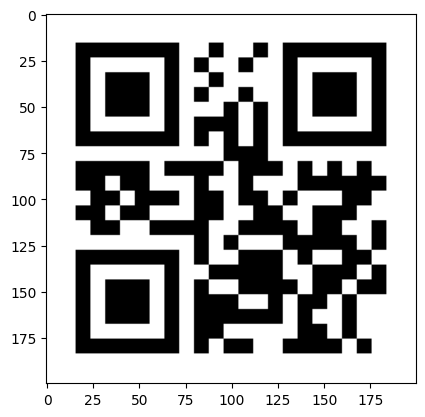

[16, 8, 40, 8, 8, 8, 16, 8, 16, 8, 40, 8, 16]
[[27, 0], [27, 16], [27, 24], [27, 64], [27, 72], [27, 80], [27, 88], [27, 104], [27, 112], [27, 128], [27, 136], [27, 176], [27, 184]]


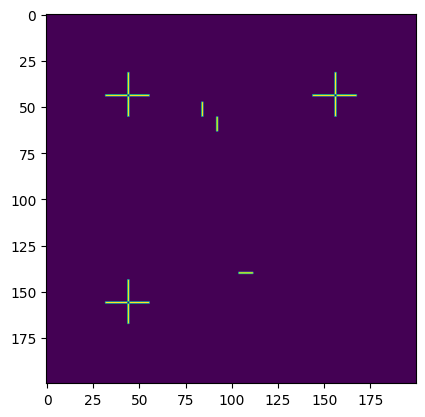

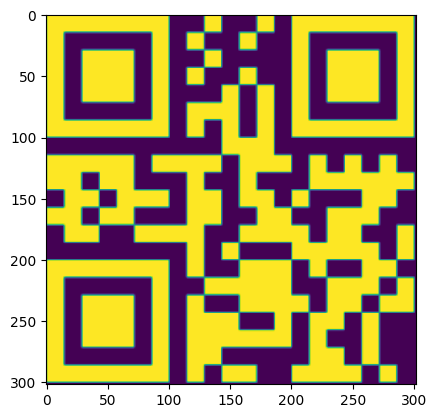

[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]


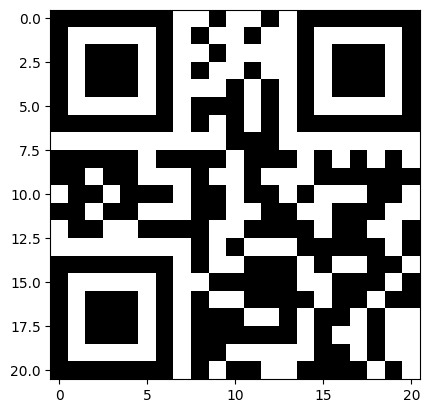

http://byu.edu


In [6]:
#Test 1
pf = Point_Finder('QR_codes/test1.png')
corners = pf.run()
final_image,corners = four_point(corners)
discrete_qr = discretize(final_image,corners)
decoding(discrete_qr)


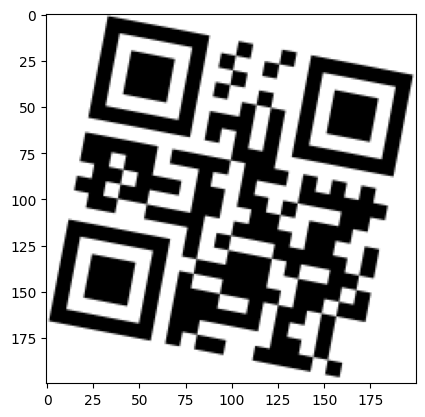

[28, 9, 8, 24, 8, 9, 8, 8, 16, 16, 8, 26, 32]
[[27, 0], [27, 28], [27, 37], [27, 45], [27, 69], [27, 77], [27, 86], [27, 94], [27, 102], [27, 118], [27, 134], [27, 142], [27, 168]]


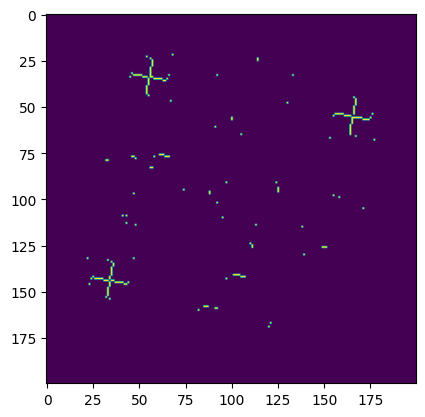

21
110
10.808230940319792
1.0


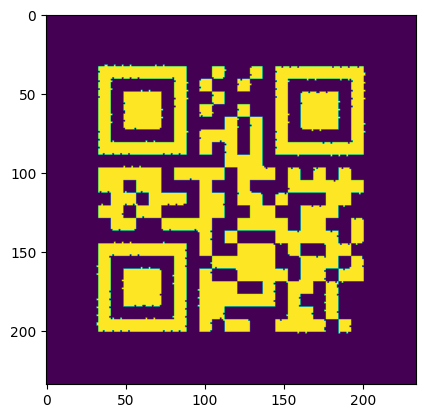

[234]
[[27, 0]]


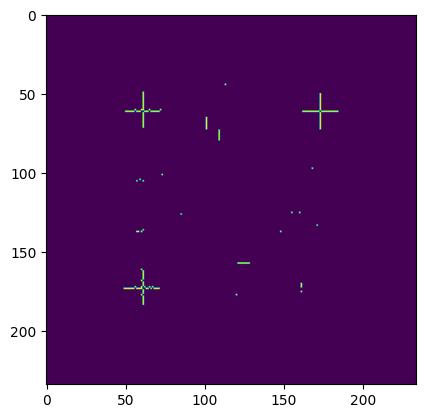

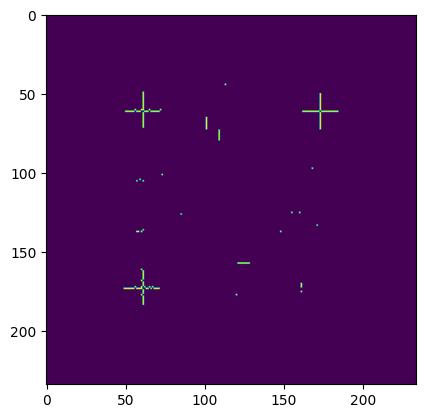

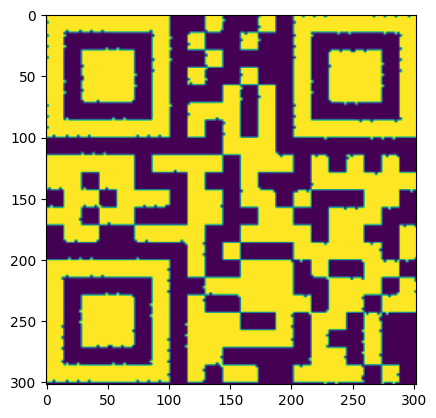

[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]


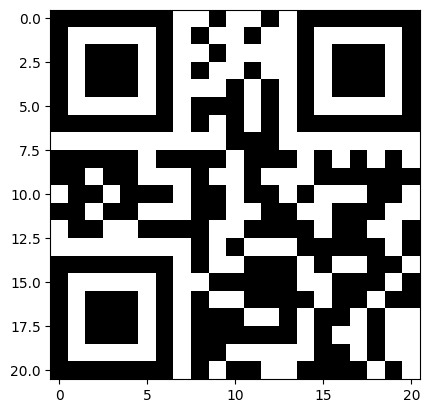

http://byu.edu


In [7]:
#Test 2
pf = Point_Finder('QR_codes/test2.png')
corners = pf.run()
final_image,corners = four_point(corners)
discrete_qr = discretize(final_image,corners)
decoding(discrete_qr)

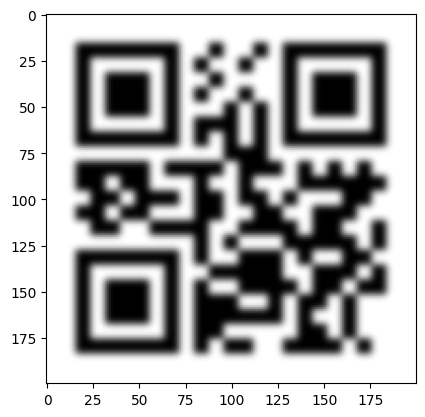

[16, 8, 40, 8, 8, 8, 16, 8, 16, 8, 40, 8, 16]
[[27, 0], [27, 16], [27, 24], [27, 64], [27, 72], [27, 80], [27, 88], [27, 104], [27, 112], [27, 128], [27, 136], [27, 176], [27, 184]]


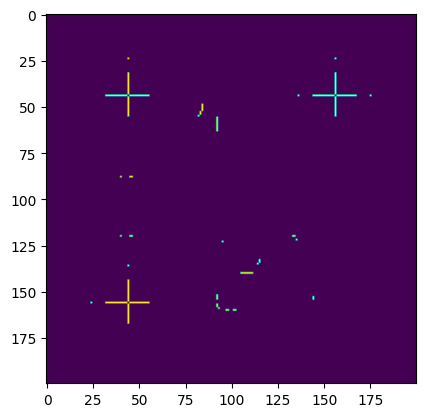

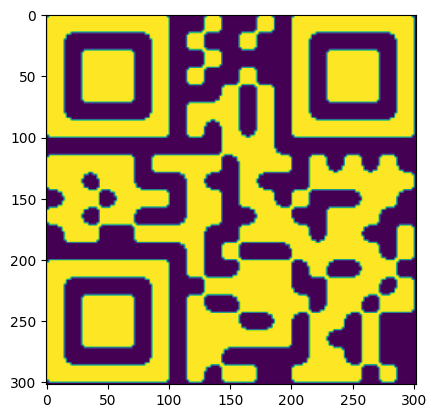

[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]


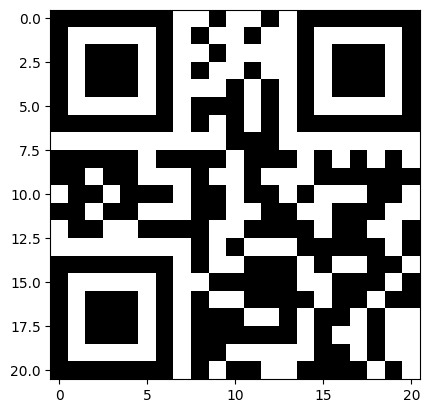

http://byu.edu


In [8]:
#Test 3
pf = Point_Finder('QR_codes/test3.png')
corners = pf.run()
final_image,corners = four_point(corners)
discrete_qr = discretize(final_image,corners)
decoding(discrete_qr)

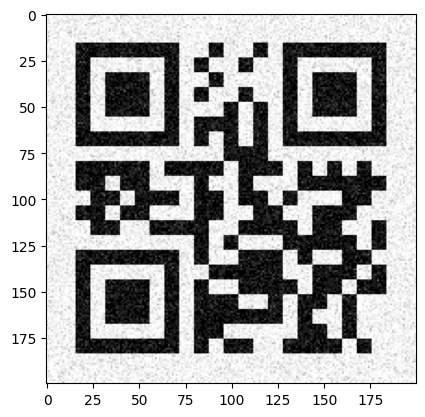

[16, 8, 40, 8, 8, 8, 16, 8, 16, 8, 40, 8, 16]
[[27, 0], [27, 16], [27, 24], [27, 64], [27, 72], [27, 80], [27, 88], [27, 104], [27, 112], [27, 128], [27, 136], [27, 176], [27, 184]]


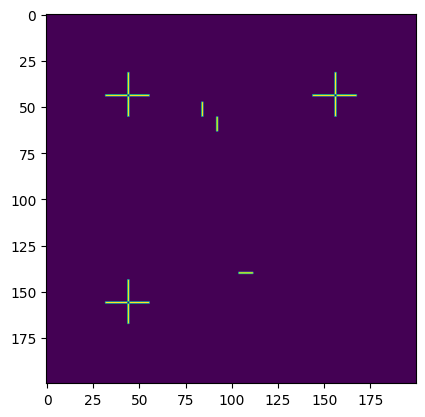

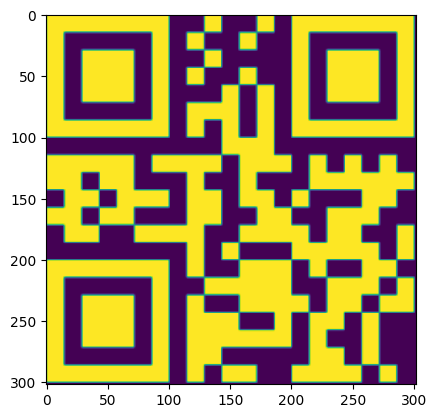

[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]


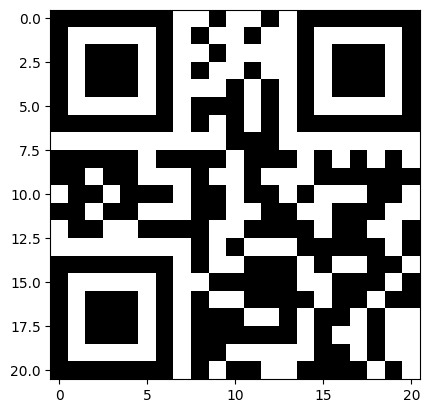

http://byu.edu


In [9]:
#Test 4
pf = Point_Finder('QR_codes/test4.png')
corners = pf.run()
final_image,corners = four_point(corners)
discrete_qr = discretize(final_image,corners)
decoding(discrete_qr)

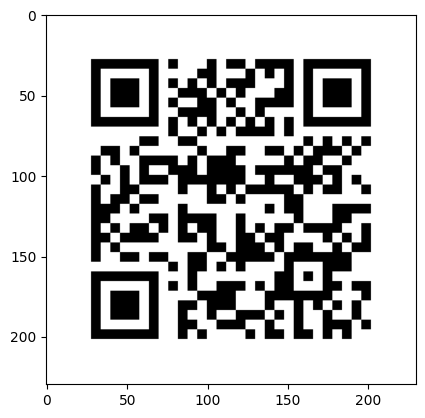

[230]
[[27, 0]]


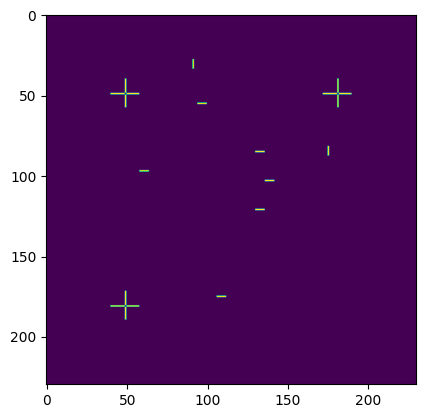

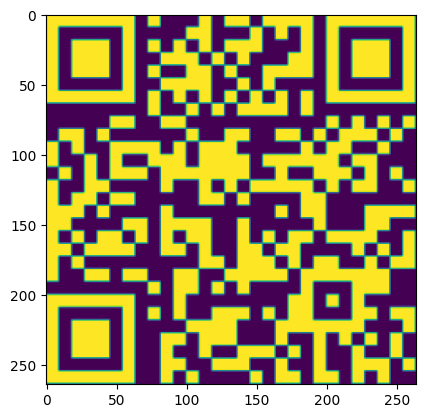

[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]


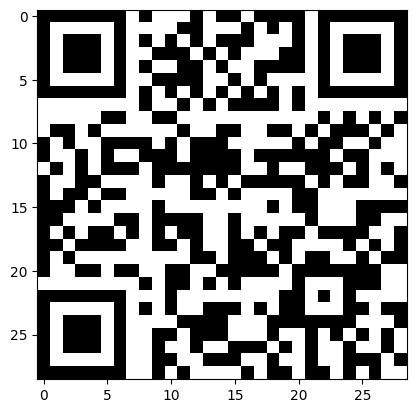

http://DataGenetics.com


In [10]:
#Test 5
pf = Point_Finder('QR_codes/test5.png')
corners = pf.run()
final_image,corners = four_point(corners)
discrete_qr = discretize(final_image,corners)
decoding(discrete_qr)

## Grading and Challenges
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Code that correctly finds the three corners of the QR code.
* [20 pts] Code that aligns the QR code and crops appropriately.
* [20 pts] Code that correctly discretizes for an arbitrary size.
* [10 pts] For a full algorithm that correctly scans the five test images.

The last 30 points are earned through completing a subset of the following challenges:

* [15 pts] Correctly scan a QR code that is misaligned by more than 90 degrees (e.g. challenge1.png)
* [15 pts] Correctly scan a QR code that is perspective shifted by using the additional alignment square present in larger QR codes. (e.g. challenge2.png)
* [15 pts] Correctly scan a QR code that is surrounded by additional pixels (e.g. challenge3.png)
* [15 pts] Correctly scan a QR code with large amounts of noise and distortion (e.g. challenge4.png)
* [30 pts] Implement a Code 128 1D bar code scanner (e.g. challenge5.png)

You may earn up to 15 points extra credit for additional challenges you complete.



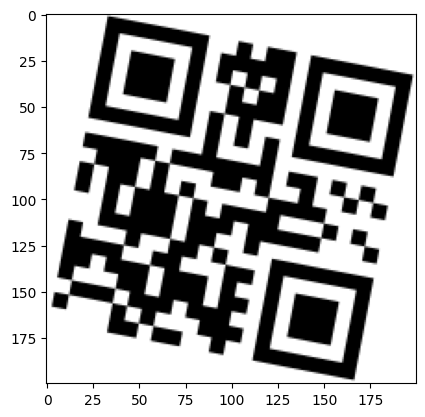

[28, 9, 8, 24, 8, 9, 8, 40, 8, 26, 32]
[[27, 0], [27, 28], [27, 37], [27, 45], [27, 69], [27, 77], [27, 86], [27, 94], [27, 134], [27, 142], [27, 168]]


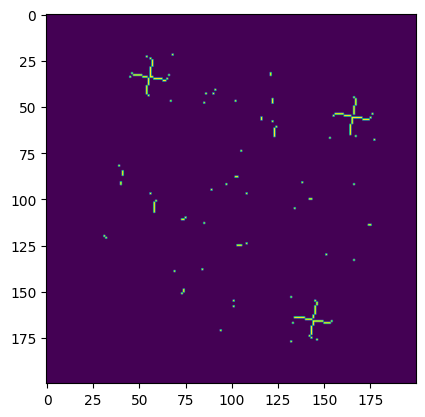

21
110
10.808230940319792
1.0


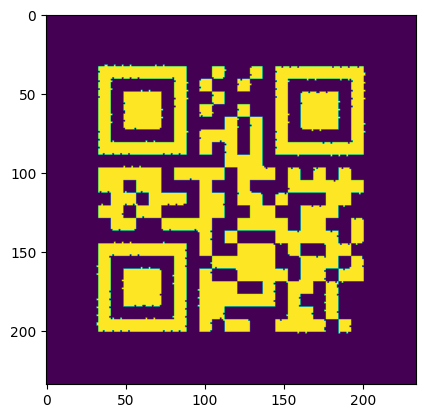

[234]
[[27, 0]]


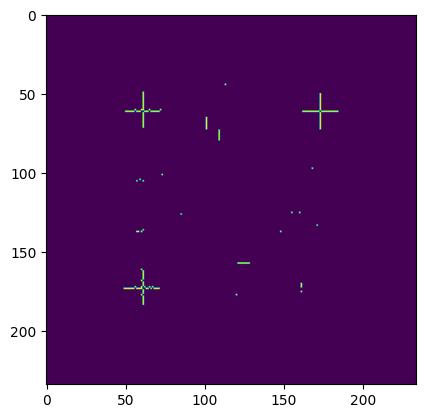

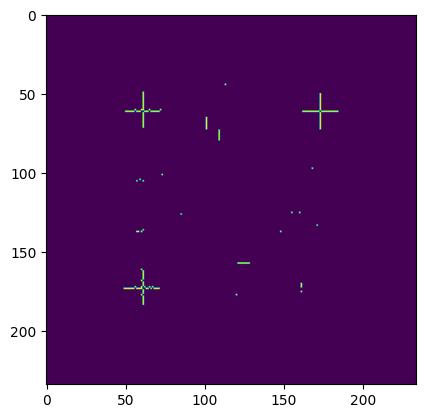

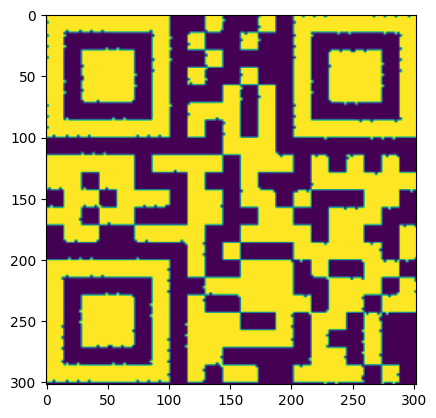

[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]


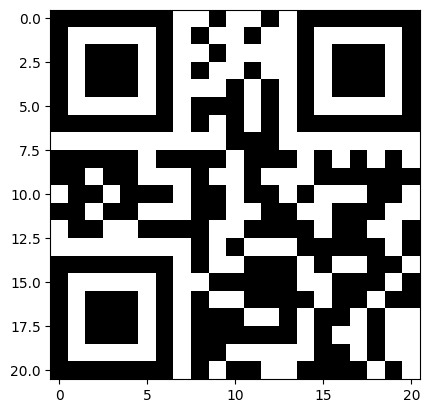

http://byu.edu


In [11]:
#Challenge 1
pf = Point_Finder('QR_codes/challenge1.png')
corners = pf.run()
final_image,corners = four_point(corners)
discrete_qr = discretize(final_image,corners)
decoding(discrete_qr)

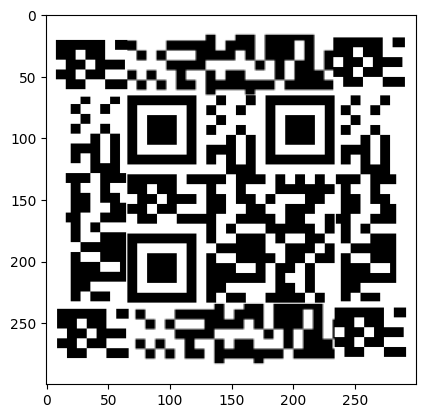

[8, 40, 8, 18, 23, 41, 7, 25, 7, 25, 7, 9, 15, 16, 8, 16, 27]
[[27, 0], [27, 8], [27, 48], [27, 56], [27, 74], [27, 97], [27, 138], [27, 145], [27, 170], [27, 177], [27, 202], [27, 209], [27, 218], [27, 233], [27, 249], [27, 257], [27, 273]]


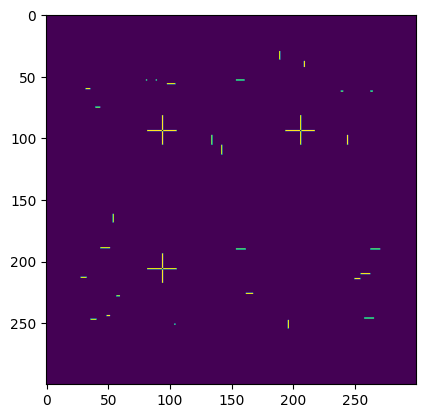

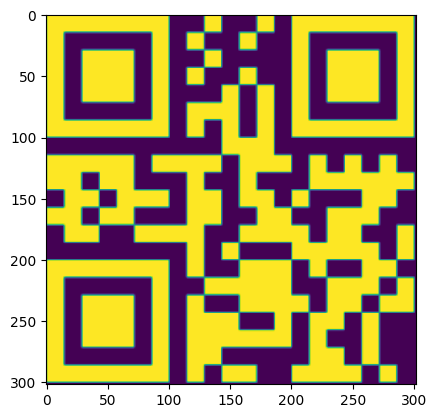

[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]


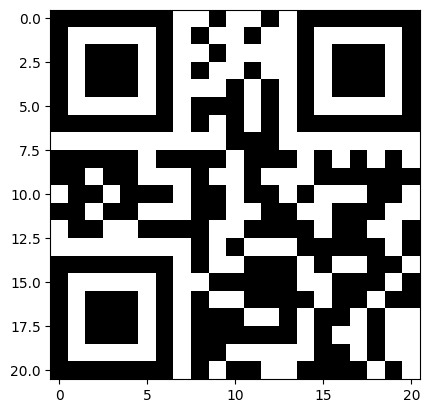

http://byu.edu


In [12]:
#Challenge 3
pf = Point_Finder('QR_codes/challenge3.png')
corners = pf.run()
final_image,corners = four_point(corners)
discrete_qr = discretize(final_image,corners)
decoding(discrete_qr)